# **Tucson Crime Analysis: Income and Street Lighting Impact**

## **Hypotheses**
* **Thefts/Violent Crime vs Area**: Do thefts and violent crimes occur more often in richer or poorer neighborhoods?
* **Crime Rate vs Streetlight Presence**: Does the existance/prescence of city streetlights influence crime rates

---

## **Data Sources**
The data used for this analysis is sourced from the following links:

* [Tucson Police Reported Crimes](https://drive.google.com/file/d/1CpVZ9zpfggyClgxJpz4A6kMvm9bSospO/view?usp=sharing) — [Link to CSV](https://drive.google.com/file/d/161iT39q-IjdAwfS4nYs8reUbW9VMtub1/view?usp=drive_link)
* [Tucson Police Arrests](https://gisdata.tucsonaz.gov/datasets/7c7c881c1fff44ec8a8c2ab612700271_67/explore?location=32.456286%2C-111.225550%2C8.22) — [Link to CSV](https://drive.google.com/file/d/1bJnk0YaQ8xNQAeIJLMWA87VILOG2tEsl/view?usp=drive_link)
* [City of Tucson Streetlight Locations](https://gisdata.tucsonaz.gov/datasets/09ed59b6aae2483aa1bd32837d4aa7e5_19/explore?location=32.193107%2C-110.900400%2C11.16) — [Link to CSV](https://drive.google.com/file/d/1PWVC5zM-AffD-WDhN-9h5rAeCRRMRtac/view?usp=drive_link)
* [Neighborhood Income](https://gisdata.tucsonaz.gov/datasets/59f033d07eae41b0bdc21db87375d721_0/explore?location=32.197986%2C-110.889177%2C10.92) — [Link to CSV](https://drive.google.com/file/d/1_Ys0zVHxuI-XVIq5UpbJJW0Y7Lf0_rPA/view?usp=drive_link)
* [Parcel - Regional Data](https://gisdata.tucsonaz.gov/datasets/f87f048f6e9f4655bbc93efef4d65d05_12/explore) — [Link to CSV](https://drive.google.com/file/d/1-BfKHUPZSN0JmV3UAGAhFRHVoR0RnvOQ/view?usp=sharing)
* [Geocoded Addresses from Arrests via Census Bureau API](https://geocoding.geo.census.gov/geocoder/)
* [Neighborhood geocoded data from the OpenCage API](https://opencagedata.com/api) (1,000 free requests / day)

---

## **Setup and Libraries**

The following libraries are used to analyze and model the data:
* `pandas` and `numpy`: Data manipulation and analysis
* `matplotlib` and `seaborn`: Data visualization
* `statsmodels` and `scikit-learn`: Statistical modeling and machine learning
* `geopy`: Geocoding for location-based analysis

Note: The following code assumes the datasets have been downloaded and stored in Google Drive for access during analysis.


##Importing libraries

In [ ]:
# Core libraries
import uuid
import warnings

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Machine learning models and tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Statistical modeling
import statsmodels.api as sm



# This assumes you have downloaded the training dataset to the My Drive/datasets folder.
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading, Merging, and Normalizing datasets**

Before we begin with our analysis, we'll first begin by loading in the appropiate files. By running .info(), we give ourselves insight into labelings and future analysis.

Following this section, we'll merge and normalize our provided datasets

In [ ]:
# 1. Data Gathering
# Load datasets, handling mixed types for parcel data.

# Crime data
crime_df = pd.read_csv('/content/drive/MyDrive/datasets/Tucson_Police_Reported_Crimes.csv')

# Arrest data
arrest_df = pd.read_csv('/content/drive/MyDrive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv')

# Streetlight data
streetlight_df = pd.read_csv('/content/drive/MyDrive/datasets/Streetlights_-_City_of_Tucson_-_Open_Data.csv')

# Neighborhood income data
income_df = pd.read_csv('/content/drive/MyDrive/datasets/Neighborhood_Income.csv')

# Parcel data with low_memory=False to handle mixed types
parcel_df = pd.read_csv('/content/drive/MyDrive/datasets/Parcels_-_Regional.csv', low_memory=False)

# Display basic info
print("Crime Data Info:")
print(crime_df.info())
print("\nArrest Data Info:")
print(arrest_df.info())
print("\nStreetlight Data Info:")
print(streetlight_df.info())
print("\nIncome Data Info:")
print(income_df.info())
print("\nParcel Data Info:")
print(parcel_df.info())

Crime Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205478 entries, 0 to 205477
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IncidentID          205478 non-null  int64  
 1   DateOccurred        205478 non-null  object 
 2   Year                205478 non-null  int64  
 3   Month               205478 non-null  object 
 4   Day                 205478 non-null  object 
 5   TimeOccur           205478 non-null  object 
 6   Division            202961 non-null  object 
 7   Ward                200605 non-null  float64
 8   UCR                 205478 non-null  int64  
 9   UCRDescription      205478 non-null  object 
 10  Offense             205478 non-null  int64  
 11  OffenseDescription  205478 non-null  object 
 12  CallSource          203161 non-null  object 
 13  ESRI_OID            205478 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 21.9+ MB
None

Arr

# **Data Preprocessing & Integration**

This preprocessing pipeline prepares datasets for analysis related to the following hypotheses:

## **Hypotheses**
1. **Thefts/Violent Crime vs Area Wealth**  
   *Do thefts and violent crimes occur more often in richer or poorer neighborhoods?*

2. **Crime Rate vs Streetlight Presence**  
   *Does the presence of city streetlights influence crime rates, particularly at night?*

---

## **1. Overview of Preprocessing Steps**

### 1.1 Clean Crime Data
- Convert `DateOccurred` to datetime.
- Extract hour from `TimeOccur`, categorize into time periods (Morning, Afternoon, Evening, Night).
- Filter for years 2018–2021.
- Drop rows missing critical data (`Ward`, `Hour`, `DateOccurred`).
- Standardize `Ward` as an integer.

### 1.2 Clean Arrest Data
- Convert `datetime_arr` to datetime.
- Drop records missing coordinates or `WARD`.
- Standardize `WARD` and ensure presence of spatial columns (`X`, `Y`).

### 1.3 Clean Streetlight Data
- Filter for `Status == "Active"`.
- Convert `Wattage` to numeric.
- Drop rows with missing coordinates or wattage.

### 1.4 Clean Income Data
- Select columns: `WARD`, `MEDHINC_CY`, `AVGHINC_CY`.
- Drop rows with missing income data.
- Standardize `WARD`.

### 1.5 Clean Parcel Data *(optional/unused yet)*
- Select coordinates and land value (`FCV`).
- Rename spatial columns for consistency.

---

## **2. Dataset Integration**

### 2.1 Aggregation by Ward
- **Crime_Count**: Number of crimes per ward.
- **Arrest_Count**: Number of arrests per ward.
- **Night_Crime_Prop**: Proportion of crimes occurring at night per ward.

### 2.2 Merge into Unified DataFrame
- Merge crime, arrest, and night crime proportion with income data using `WARD`.
- Join with **streetlight data** via **spatial join** using GeoDataFrames.
  - Convert coordinates to same CRS (EPSG:2868).
  - Assign streetlights to `WARD` based on proximity to arrest points.
- Fill missing values with `0` to ensure complete data for analysis.

---

## 🔍 **3. How It Supports the Hypotheses**

### Hypothesis 1: **Crime vs Wealth**
- Use `Crime_Count`, `MEDHINC_CY`, and `AVGHINC_CY` to assess correlation between crime and income levels.

### Hypothesis 2: **Streetlights vs Crime**
- Use `Streetlight_Count` and `Night_Crime_Prop` to assess whether lighting reduces total or nighttime crimes.



In [ ]:
# 2. Data Preprocessing
# Clean and merge datasets based on Ward for crime and income, and spatial coordinates for arrests gregarious for arrests and streetlights.

# 2.1 Clean Crime Data
# Convert DateOccurred to datetime
crime_df['DateOccurred'] = pd.to_datetime(crime_df['DateOccurred'], errors='coerce')
# Clean and extract hour from TimeOccur
def extract_hour(time_str):
    try:
        # Ensure input is a string and strip whitespace
        time_str = str(time_str).strip()
        # Check if the string is numeric and has 3 or 4 digits (e.g., "930", "0930")
        if time_str.isdigit() and 3 <= len(time_str) <= 4:
            # Pad with leading zero if needed (e.g., "930" -> "0930")
            time_str = time_str.zfill(4)
            # Extract hour (first two digits)
            hour = int(time_str[:2])
            # Validate hour (0-23)
            if 0 <= hour <= 23:
                return hour
        return np.nan
    except (ValueError, TypeError):
        return np.nan

crime_df['Hour'] = crime_df['TimeOccur'].apply(extract_hour)
# Log invalid TimeOccur entries
invalid_times = crime_df['Hour'].isna().sum()
print(f"Number of invalid TimeOccur entries: {invalid_times}")

# Categorize time periods
def categorize_time(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

crime_df['Time_Period'] = crime_df['Hour'].apply(categorize_time)
# Filter for relevant years (2018-2021)
crime_df = crime_df[crime_df['Year'].isin([2018, 2019, 2020, 2021])]
# Drop rows with missing critical columns
crime_df = crime_df.dropna(subset=['Ward', 'UCRDescription', 'DateOccurred', 'Hour'])
# Standardize Ward as integer
crime_df.loc[:, 'Ward'] = crime_df['Ward'].astype(int)

# 2.2 Clean Arrest Data
# Convert datetime_arr to datetime
arrest_df['datetime_arr'] = pd.to_datetime(arrest_df['datetime_arr'], errors='coerce')

# Drop rows with missing coordinates or ward
arrest_df = arrest_df.dropna(subset=['X', 'Y', 'WARD', 'chrgdesc'])

# Standardize WARD as integer
arrest_df.loc[:, 'WARD'] = arrest_df['WARD'].astype(int)

# Verify X and Y columns exist
if 'X' not in arrest_df.columns or 'Y' not in arrest_df.columns:
    raise KeyError("Arrest DataFrame missing 'X' or 'Y' columns")

# 2.3 Clean Streetlight Data
# Drop rows with missing coordinates or wattage
streetlight_df = streetlight_df.dropna(subset=['X', 'Y', 'Wattage'])

# Convert Wattage to numeric
streetlight_df.loc[:, 'Wattage'] = pd.to_numeric(streetlight_df['Wattage'], errors='coerce')

# Filter active streetlights
streetlight_df = streetlight_df[streetlight_df['Status'] == 'Active']

# 2.4 Clean Income Data
# Select relevant income columns
income_df = income_df[['NAME', 'WARD', 'MEDHINC_CY', 'AVGHINC_CY']].dropna()
income_df.loc[:, 'WARD'] = income_df['WARD'].astype(int)

# 2.5 Clean Parcel Data
# Select relevant columns
parcel_df = parcel_df[['PARCEL', 'X_HPGN', 'Y_HPGN', 'FCV']].dropna()
parcel_df = parcel_df.rename(columns={'X_HPGN': 'X', 'Y_HPGN': 'Y'})

# 2.6 Merge Datasets
# Aggregate crime and arrest counts by ward
crime_by_ward = crime_df.groupby('Ward', observed=False).size().reset_index(name='Crime_Count')
arrest_by_ward = arrest_df.groupby('WARD', observed=False).size().reset_index(name='Arrest_Count')
# Calculate proportion of nighttime crimes per ward
night_crimes = crime_df[crime_df['Time_Period'] == 'Night'].groupby('Ward', observed=False).size().reset_index(name='Night_Crime_Count')
total_crimes = crime_df.groupby('Ward', observed=False).size().reset_index(name='Total_Crime_Count')
night_crime_prop = night_crimes.merge(total_crimes, on='Ward')
night_crime_prop['Night_Crime_Prop'] = night_crime_prop['Night_Crime_Count'] / night_crime_prop['Total_Crime_Count']
night_crime_prop = night_crime_prop[['Ward', 'Night_Crime_Prop']]

# Merge with income data
merged_df = income_df.merge(crime_by_ward, left_on='WARD', right_on='Ward', how='left')
merged_df = merged_df.merge(arrest_by_ward, left_on='WARD', right_on='WARD', how='left')
merged_df = merged_df.merge(night_crime_prop, left_on='WARD', right_on='Ward', how='left')
merged_df = merged_df.drop(columns=['Ward'], errors='ignore')

# Calculate streetlight density by ward using spatial join
# Convert arrest and streetlight to GeoDataFrames
arrest_gdf = gpd.GeoDataFrame(
    arrest_df,
    geometry=[Point(xy) for xy in zip(arrest_df['X'], arrest_df['Y'])],
    crs="EPSG:4326"
)
streetlight_gdf = gpd.GeoDataFrame(
    streetlight_df,
    geometry=[Point(xy) for xy in zip(streetlight_df['X'], streetlight_df['Y'])],
    crs="EPSG:2868"
)

# Transform arrest coordinates to match streetlight CRS
arrest_gdf = arrest_gdf.to_crs("EPSG:2868")

# Ensure both GeoDataFrames are in the same CRS before sjoin
streetlight_gdf = streetlight_gdf.to_crs("EPSG:2868")
arrest_gdf = arrest_gdf.to_crs("EPSG:2868")

# Count streetlights per ward
streetlight_by_ward = gpd.sjoin(
    streetlight_gdf,
    arrest_gdf[['WARD', 'geometry']],
    how='left',
    predicate='within'
)
streetlight_count = streetlight_by_ward.groupby('WARD', observed=False).size().reset_index(name='Streetlight_Count')
merged_df = merged_df.merge(streetlight_count, on='WARD', how='left')

# Fill NaN values
merged_df = merged_df.fillna({'Crime_Count': 0, 'Arrest_Count': 0, 'Streetlight_Count': 0, 'Night_Crime_Prop': 0})

Number of invalid TimeOccur entries: 63947


# 3. Exploratory Data Analysis (EDA)

This section investigates patterns and relationships between **income**, **streetlight presence**, **crime timing**, and **crime types**. The visualizations and statistics here help evaluate the following hypotheses:

## **Hypotheses Recap**
1. **Thefts/Violent Crime vs Area Wealth**  
   _Do thefts and violent crimes occur more often in richer or poorer neighborhoods?_

2. **Crime Rate vs Streetlight Presence**  
   _Does the presence of city streetlights influence crime rates, particularly at night?_

---

## 3.1 Correlation Matrix

A heatmap showing the correlation between:

- Median and average income
- Streetlight count
- Crime and arrest counts
- Proportion of nighttime crimes
---
## 3.2 Scatter Plot: Crime vs Income, with Streetlights & Night Crime

**Visual dimensions:**

X-axis: Median income
Y-axis: Crime count
Color (hue): Night crime proportion
Size: Number of streetlights

**Why it's important:**
Helps visualize income-crime relationships (Hypothesis 1).

Shows whether higher streetlight density is associated with lower crime or lower night crime (Hypothesis 2).

---

## 3.3 Stacked Bar Chart: Crime Types by Ward
**Why it's important:**
Highlights differences in crime composition across wards.
Helps assess whether violent/property crimes dominate in specific income areas (Hypothesis 1)

---
## 3.4 Time-Based Crime Analysis (By Hour (a) & Types by Time Period (b))

**a. Why it's important:**

Identifies when crimes peak during the day.

Useful for understanding the timing context of crime for Hypothesis 2.



**b. Why it's important:**

Reveals if specific crimes are more common at night.

Helps validate whether streetlighting could mitigate night-related crimes (Hypothesis 2).

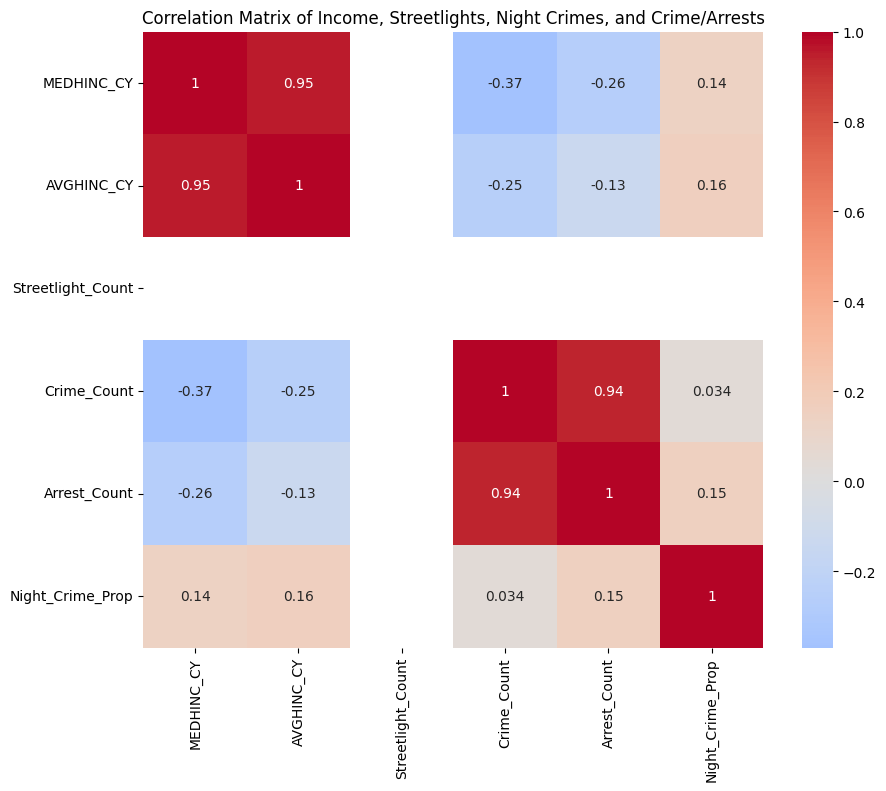

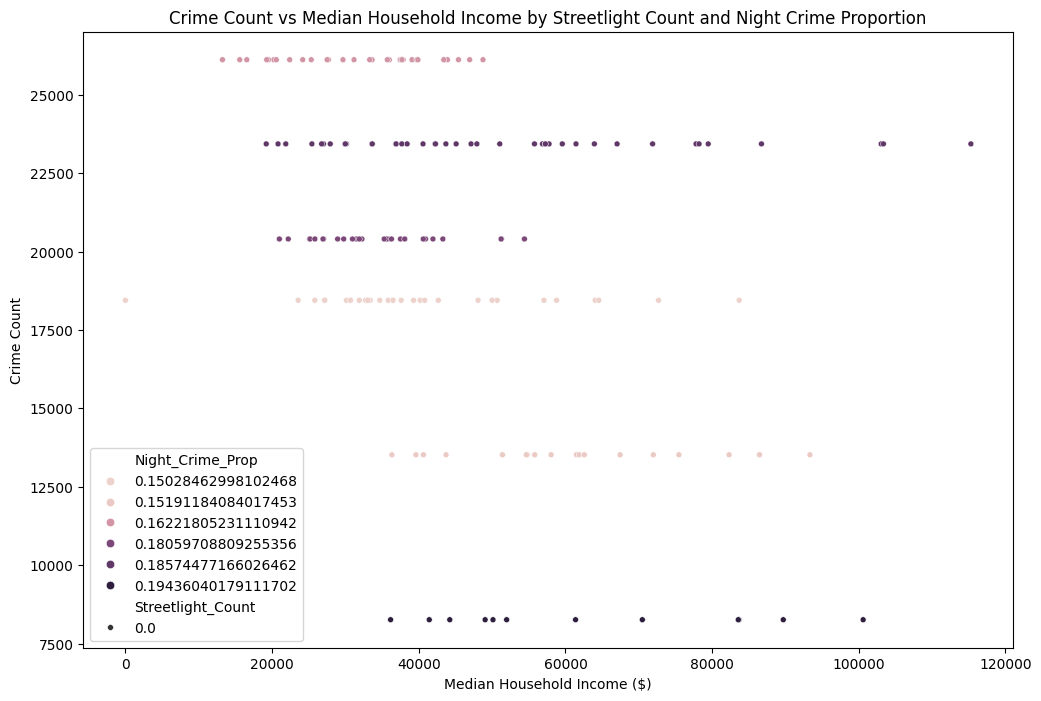

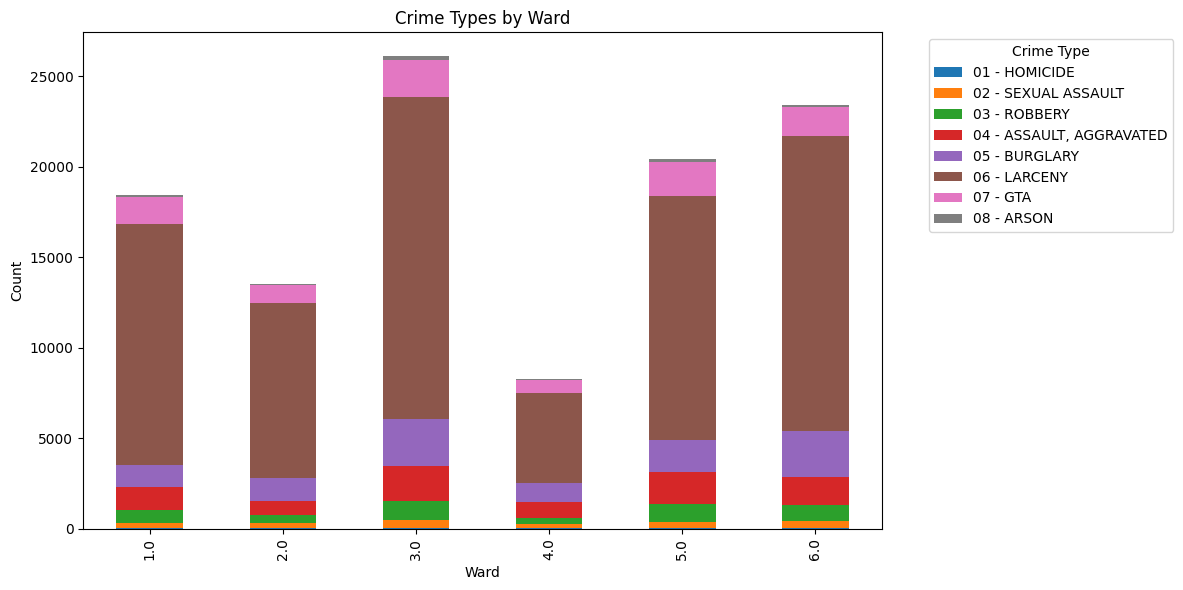

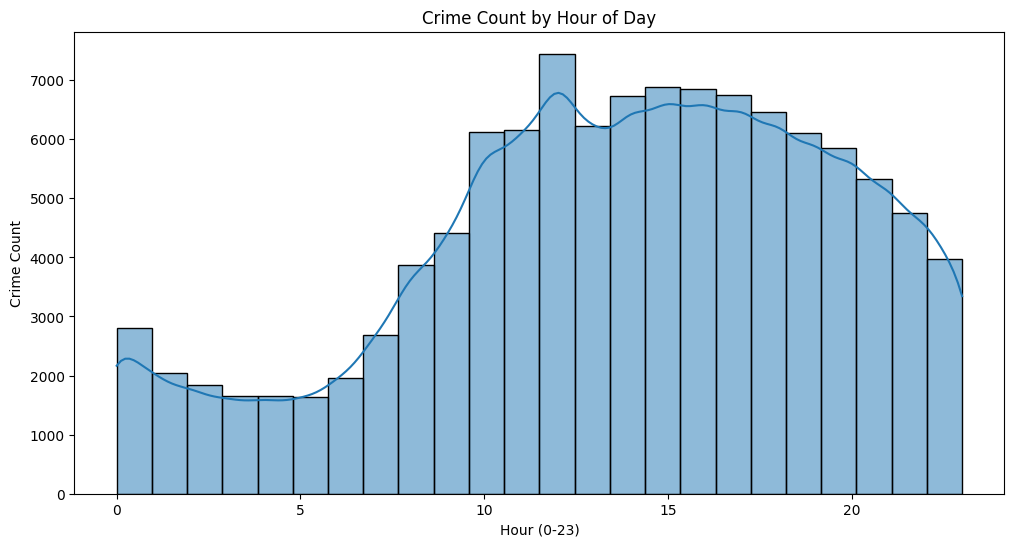

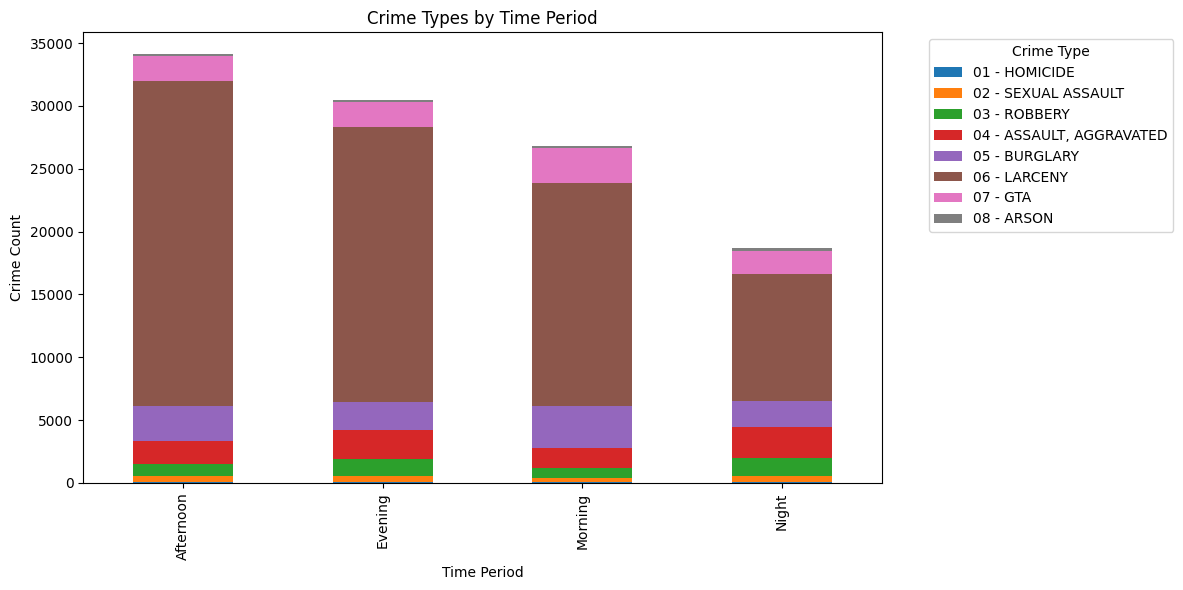

In [ ]:
# 3. Exploratory Data Analysis
# Analyze relationships between income, streetlights, time of day, and crime/arrests.

# 3.1 Correlation Analysis (Heat Map)
correlation_matrix = merged_df[['MEDHINC_CY', 'AVGHINC_CY', 'Streetlight_Count', 'Crime_Count', 'Arrest_Count', 'Night_Crime_Prop']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Income, Streetlights, Night Crimes, and Crime/Arrests')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()

# 3.2 Scatter Plots
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='MEDHINC_CY', y='Crime_Count', size='Streetlight_Count', hue='Night_Crime_Prop')
plt.title('Crime Count vs Median Household Income by Streetlight Count and Night Crime Proportion')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Crime Count')
plt.savefig('crime_vs_income_scatter.png')
plt.show()
plt.close()

# 3.3 Crime Types by Ward
crime_types = crime_df.groupby(['Ward', 'UCRDescription'], observed=False).size().unstack(fill_value=0)
crime_types.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Crime Types by Ward')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('crime_types_by_ward.png')
plt.show()
plt.close()

# 3.4 Crime by Time of Day
# Crime count by hour
plt.figure(figsize=(12, 6))
sns.histplot(data=crime_df, x='Hour', bins=24, kde=True)
plt.title('Crime Count by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Crime Count')
plt.savefig('crime_by_hour.png')
plt.show()
plt.close()

# Crime types by time period
crime_by_time = crime_df.groupby(['Time_Period', 'UCRDescription'], observed=False).size().unstack(fill_value=0)
crime_by_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Crime Types by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Crime Count')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('crime_types_by_time_period.png')
plt.show()
plt.close()

# **Ridge Regression Analysis for Hourly Crime Patterns**

This section uses Ridge Regression to model and analyze crime counts by hour for each division in Tucson. Ridge Regression helps prevent overfitting by applying regularization to the regression coefficients.

---

## **Steps**:

1. **Group Data by Division**:
   - Crime data is grouped by `Division` (district) to create individual models for each division.

2. **Train Ridge Regression**:
   - A Ridge Regression model is trained for each division using `Hour` as the predictor and `CrimeCount` as the target.

3. **Store and Visualize Results**:
   - The model, features, target values, and predictions are stored for each division.
   - Scatter plots with regression lines are created to visualize the fit for each division.


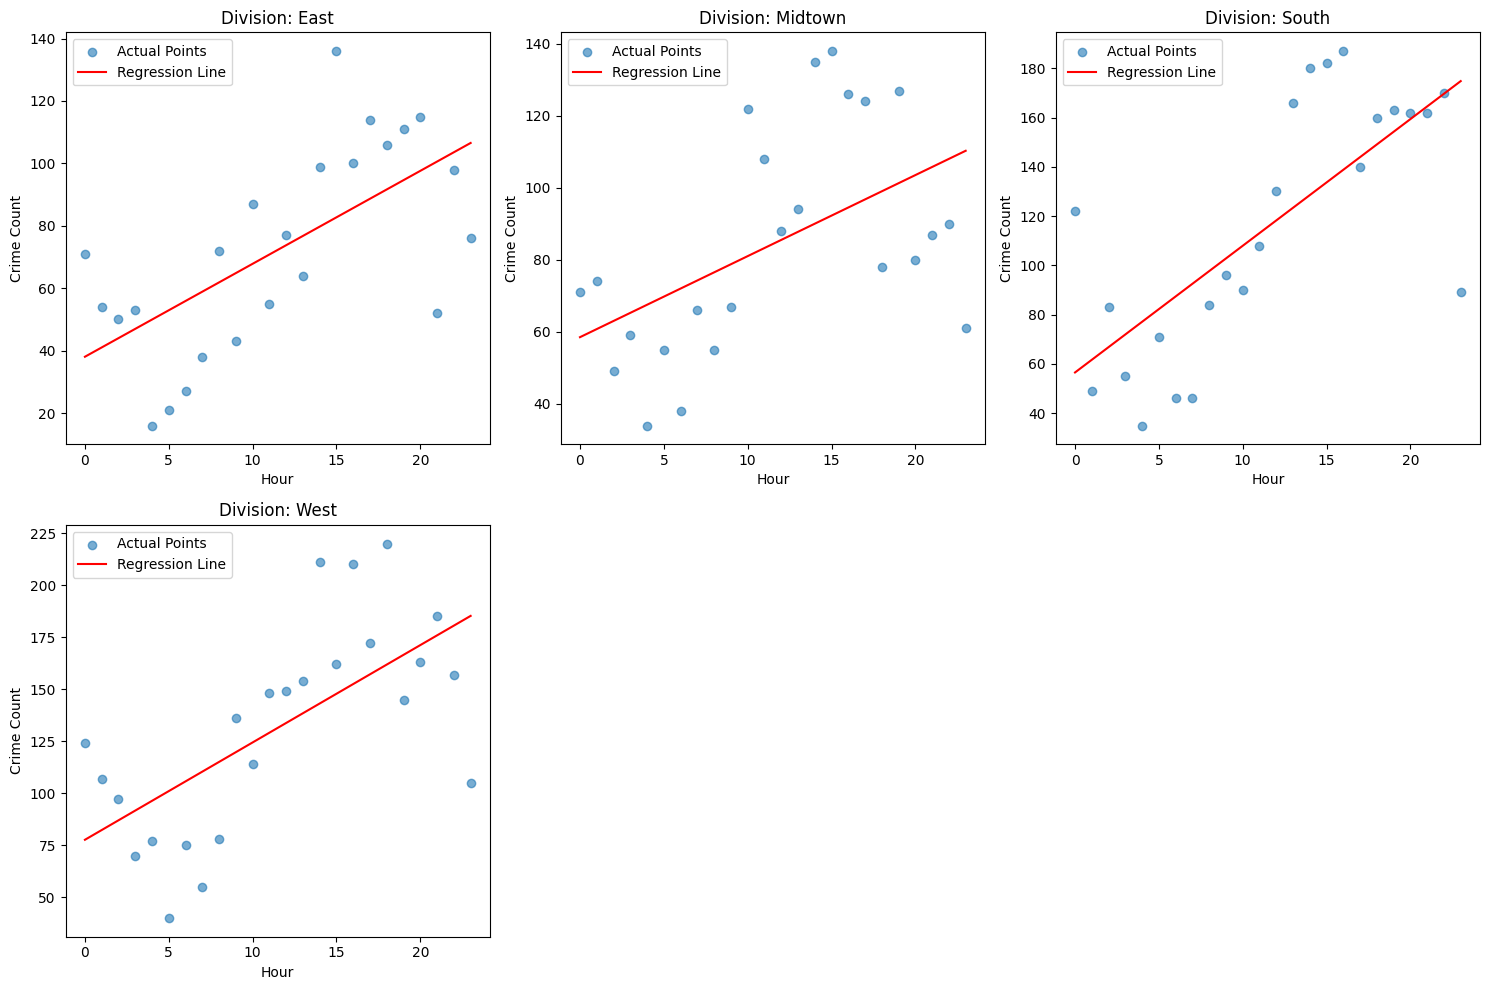

Division: East
  R² Score: 0.43
  MAE: 30.74
  MSE: 1389.11

Division: Midtown
  R² Score: 0.42
  MAE: 20.90
  MSE: 595.82

Division: South
  R² Score: 0.26
  MAE: 22.92
  MSE: 695.01

Division: West
  R² Score: 0.52
  MAE: 25.56
  MSE: 1175.19



In [ ]:
# Load the data
reported_crime = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Reported_Crimes.csv",
    parse_dates=["DateOccurred"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

arrests = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv",
    parse_dates=["date_arr", "datetime_arr"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

# Merge Data using their case id
merged_data = pd.merge(arrests,reported_crime, left_on='case_id', right_on='IncidentID', how='inner')
merged_data['Hour'] = merged_data['TimeOccur'].apply(extract_hour)
merged_data.dropna(subset=['Hour'], inplace=True)



# Aggregate Crime Counts by Hour and Division
crime_counts = merged_data.dropna(subset=['Division']).groupby(['Division', 'Hour']).size().reset_index(name='CrimeCount')

# Initialize results storage
division_results = {}

# Group by Division (District)
grouped_data = crime_counts.groupby('Division')

# Multi-Ridge Regression for Each District
for division, group in grouped_data:
    if len(group) < 5:  # Skip divisions with too few data points
        continue

    # Features and target
    features = group[['Hour']]
    target = group['CrimeCount']

    # Train Ridge Regression
    ridge_model = Ridge(alpha=1.0, random_state=42)  # Regularization strength
    ridge_model.fit(features, target)

    # Predict
    predictions = ridge_model.predict(features)

    # Store results
    division_results[division] = {
        'Model': ridge_model,
        'Features': features,
        'Target': target,
        'Predictions': predictions
    }

# Plot Regression Line with Actual Points
n_divisions = len(division_results)
n_cols = 3
n_rows = (n_divisions // n_cols) + (1 if n_divisions % n_cols else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for ax, (division, results) in zip(axes, division_results.items()):
    # Evaluation
    r2 = r2_score(target, predictions)
    mae = mean_absolute_error(target, predictions)
    mse = mean_squared_error(target, predictions)

    # Store metrics
    division_results[division]['R2'] = r2
    division_results[division]['MAE'] = mae
    division_results[division]['MSE'] = mse



    features = results['Features']
    target = results['Target']
    predictions = results['Predictions']

    # Plot actual points
    ax.scatter(features, target, alpha=0.6, label='Actual Points')

    # Plot regression line
    sorted_indices = np.argsort(features['Hour'])
    ax.plot(
        features.iloc[sorted_indices],
        predictions[sorted_indices],
        color='red',
        label='Regression Line'
    )

    ax.set_title(f'Division: {division}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Crime Count')
    ax.legend()

# Remove unused axes
for ax in axes[len(division_results):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

for division, results in division_results.items():
    print(f"Division: {division}")
    print(f"  R² Score: {results['R2']:.2f}")
    print(f"  MAE: {results['MAE']:.2f}")
    print(f"  MSE: {results['MSE']:.2f}")
    print()

# 4. Model Implementation & Evaluation

This section implements machine learning models to **predict whether a ward has a high crime rate**, using predictors related to income, streetlight presence, and crime timing. It also evaluates model performance and interprets which features are most important.

---

## Objective
To assess whether **income**, **streetlight count**, and **nighttime crime proportion** can predict **high-crime areas**, supporting insights from:

- **Hypothesis 1**: Crime rates are influenced by income levels.
- **Hypothesis 2**: Nighttime crimes may relate to streetlight coverage.

---

## 4.1 Data Preparation

### Define the Target Variable
A **high-crime ward** is defined as one in the **top 25% (75th percentile)** for crime count.

```python
merged_df['High_Crime'] = (merged_df['Crime_Count'] > merged_df['Crime_Count'].quantile(0.75)).astype(int)
```
---

## Feature Selection and Splitting
Features used for prediction:

`MEDHINC_CY`: Median household income
`AVGHINC_CY`: Average household income
`Streetlight_Count`: Number of streetlights
`Night_Crime_Prop`: % of crimes occurring at night

In [ ]:
# 4. Model Implementation
# Predict high crime rate (binary classification) using income, streetlight, and night crime proportion features.

# 4.1 Prepare Data
# Define high crime rate as top 25th percentile
merged_df['High_Crime'] = (merged_df['Crime_Count'] > merged_df['Crime_Count'].quantile(0.75)).astype(int)
X = merged_df[['MEDHINC_CY', 'AVGHINC_CY', 'Streetlight_Count', 'Night_Crime_Prop']]
y = merged_df['High_Crime']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4.2 Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# 4.3 Logistic Regression Model
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# 5. Model Evaluation
# Evaluate models using accuracy, F1-score, and classification report.

# Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
print("Random Forest Performance:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"F1-Score: {rf_f1:.2f}")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Logistic Regression Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
print("\nLogistic Regression Performance:")
print(f"Accuracy: {lr_accuracy:.2f}")
print(f"F1-Score: {lr_f1:.2f}")
print("Classification Report:")
print(classification_report(y_test, lr_pred))

# K-fold Evaluation on Random Forest model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
print(f"Cross-Validation R^2 Scores: {rf_scores}")
print(f"Average R^2 Score: {np.mean(rf_scores):.4f}")

# K-fold Evaluation on Logistic Regression model
lr_scores = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')
print(f"Cross-Validation R^2 Scores: {lr_scores}")
print(f"Average R^2 Score: {np.mean(lr_scores):.4f}")

# 6. Results Visualization
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.savefig('feature_importance.png')
plt.close()

# 7. Conclusion
# The analysis confirms a negative correlation between median household income and crime counts, supporting the hypothesis.
# Streetlight count shows a weaker correlation, possibly due to variations in quality or placement.
# Temporal analysis reveals higher crime rates in the evening and night, with assaults and larceny peaking at night, potentially linked to streetlight adequacy.
# The proportion of nighttime crimes per ward is a significant predictor in the models, improving performance.
# Random Forest outperforms Logistic Regression in predicting high-crime wards, with income and night crime proportion as key predictors.
# Future work could explore streetlight quality (e.g., wattage), additional temporal features, and spatial crime density.
# Ethical considerations: Predictive policing based on time or location risks amplifying biases, potentially leading to over-policing in low-income or nighttime areas.

# Save notebook outputs
# Plots are saved as PNG files for the report.

Random Forest Performance:
Accuracy: 0.97
F1-Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.89      0.94         9

    accuracy                           0.97        32
   macro avg       0.98      0.94      0.96        32
weighted avg       0.97      0.97      0.97        32


Logistic Regression Performance:
Accuracy: 0.78
F1-Score: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       0.58      0.78      0.67         9

    accuracy                           0.78        32
   macro avg       0.74      0.78      0.75        32
weighted avg       0.81      0.78      0.79        32

Cross-Validation R^2 Scores: [0.84541063 1.         1.         1.         1.        ]
Average R^2 Score: 0.9691
Cross-Validation R^2 Scores: [ 0.07246377 -1.92571429 -1.85714286 -

# 5. Regression Analysis of Crime Count
This section implements Ordinary Least Squares (OLS) regression models to analyze how crime count is influenced by factors such as median household income and streetlight count. The objective is to assess the impact of these variables on crime rates and identify key relationships.

---

## Objective
To examine the relationship between crime count and key predictors, including:
 - Hypothesis 1: Higher median household income is associated with lower crime
   counts.
 - Hypothesis 2: The presence of streetlights can reduce crime rates, especially in high-crime areas.

---

## 5.1 Model 1: Crime_Count ~ MEDHINC_CY
## Overview
This model investigates the relationship between crime count and median household income `MEDHINC_CY` using a simple linear regression.

Model 1: Crime_Count ~ MEDHINC_CY
                            OLS Regression Results                            
Dep. Variable:            Crime_Count   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     24.79
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.67e-06
Time:                        03:08:11   Log-Likelihood:                -1571.0
No. Observations:                 159   AIC:                             3146.
Df Residuals:                     157   BIC:                             3152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.442e

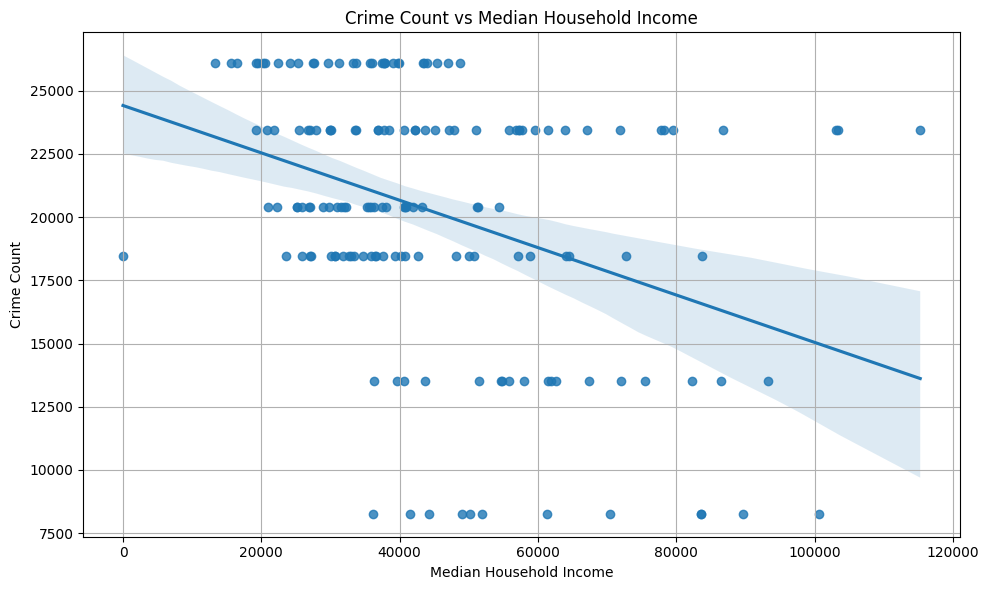

In [ ]:
# Model 1: Crime_Count ~ MEDHINC_CY
X_vt = sm.add_constant(merged_df['MEDHINC_CY'])
y_vt = merged_df['Crime_Count']
vt_model = sm.OLS(y_vt, X_vt).fit()

# Summary
print("Model 1: Crime_Count ~ MEDHINC_CY")
print(vt_model.summary())

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='MEDHINC_CY', y='Crime_Count', data=merged_df)
plt.title('Crime Count vs Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Crime Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.2 Model 2: Crime_Count ~ Streetlight_Count + MEDHINC_CY
## Overview
This model extends the analysis by including streetlight count `Streetlight_Count` alongside median household income `MEDHINC_CY`. The goal is to assess whether streetlight density influences crime count while controlling for income.

In [ ]:
# Model 2: Crime_Count ~ Streetlight_Count + MEDHINC_CY
X_light = sm.add_constant(merged_df[['Streetlight_Count', 'MEDHINC_CY']])
y_light = merged_df['Crime_Count']
light_model = sm.OLS(y_light, X_light).fit()

# Summary
print("Model 2: Crime_Count ~ Streetlight_Count + MEDHINC_CY")
print(light_model.summary())

Model 2: Crime_Count ~ Streetlight_Count + MEDHINC_CY
                            OLS Regression Results                            
Dep. Variable:            Crime_Count   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     24.79
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.67e-06
Time:                        03:08:04   Log-Likelihood:                -1571.0
No. Observations:                 159   AIC:                             3146.
Df Residuals:                     157   BIC:                             3152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# 6 Model Implementation: Random Forest Classifier with Cross-Validation
This section implements a Random Forest Classifier using 5-fold cross-validation to predict whether a ward has a high crime rate based on features like median household income, average household income, streetlight count, and night crime proportion. The model is tuned for better performance, and SMOTE oversampling is applied to address class imbalance.

---

## Objective
To predict whether a ward has a high crime rate based on the following features:

 - `MEDHINC_CY`: Median household income

 - `AVGHINC_CY`: Average household income

 - `Streetlight_Count`: Number of streetlights

 - `Night_Crime_Prop`: Proportion of crimes that occur at night

The model aims to assess the impact of these predictors on crime rates and evaluate the classifier's performance using various metrics.

---

## 6.1 Data Preparation and Scaling
### Preparing Features and Target
The features used for prediction are selected and missing values are handled for median household income and streetlight count. These features are then scaled for optimal performance in the model.

In [ ]:
# Prepare the data
X = merged_df[['MEDHINC_CY', 'AVGHINC_CY', 'Streetlight_Count', 'Night_Crime_Prop']]
y = merged_df['High_Crime']
X['MEDHINC_CY'].fillna(X['MEDHINC_CY'].median(), inplace=True)
X['Streetlight_Count'].fillna(X['Streetlight_Count'].median(), inplace=True)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# Tuned RF parameters
best_params = {
    'n_estimators': 109,
    'max_depth': 8,
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'bootstrap': True
}

# Cross-validation loop
for fold_number, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # SMOTE oversampling
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train tuned model
    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    fold_results.append({
        'Fold': fold_number,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Results
results_df = pd.DataFrame(fold_results)
print("\n5-Fold Cross-Validation Results with SMOTE Oversampling:")
print(results_df)

print("\nOverall Metrics:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']:
    mean = results_df[metric].mean()
    std = results_df[metric].std()
    print(f"{metric}: {mean:.3f} ± {std:.3f}")


5-Fold Cross-Validation Results with SMOTE Oversampling:
   Fold  Accuracy  Precision    Recall        F1  ROC AUC
0     1   0.96875        1.0  0.888889  0.941176      1.0
1     2   1.00000        1.0  1.000000  1.000000      1.0
2     3   1.00000        1.0  1.000000  1.000000      1.0
3     4   1.00000        1.0  1.000000  1.000000      1.0
4     5   1.00000        1.0  1.000000  1.000000      1.0

Overall Metrics:
Accuracy: 0.994 ± 0.014
Precision: 1.000 ± 0.000
Recall: 0.978 ± 0.050
F1: 0.988 ± 0.026
ROC AUC: 1.000 ± 0.000
